## Check of 5 empirical facts of fin corr matrices, for simulated corrs among equity indices

### Financial correlation matrices tend to present the following stylized facts:

1. Distribution of pairwise correlations is significantly shifted to the positive,
2. Eigenvalues follow the Marchenko–Pastur distribution, but for:
    - a very large first eigenvalue,
    - a couple of other large eigenvalues,
3. Perron-Frobenius property (first eigenvector has positive entries), 
4. Hierarchical structure of clusters,  
5. Scale-free property of the corresponding MST.

This project explores the use of Variational Auto-Encoders (VAEs) to generate matrices that adhere to commonly observed correlation properties. Our focus is specifically on correlations among equity indices.

One notable aspect of our approach is the potential for explainability regarding how the correlation matrix may change over time—a desirable feature for financial applications.

The data utilized in our study is sourced from Datastream.

Example Illustration: Italian Default Rates

In this repository, we provide an example employing freely available data. The data, obtained from https://infostat.bancaditalia.it/, pertains to Italian default rates. We employ a spline method for data elaboration in this instance. Feel free to explore and adapt our methodology for your own research and applications.

Import some packages.

In [2]:
import pandas as pd
import numpy as np
from numpy.random import beta
from numpy.random import randn
from scipy.linalg import sqrtm
from numpy.random import seed
from random import randint
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import torch
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
from torch.utils.data import Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import random
%matplotlib inline

# 1. Correlation coefficients are mostly positive, and their mean usually above 0.3

### Reading the synthetic matrices simulated with "Simulation_VAE"

In [3]:
db = pd.read_excel('corr_matrices_latent_space_full_sampling.xlsx', index_col = 0)
corr_mats = db.to_numpy()

In [4]:
len(corr_mats)

132

In [5]:
DIM_MAT = 32 #number of features

In [6]:
corr_mats[0].reshape(DIM_MAT,DIM_MAT)

array([[0.99491948, 0.77758092, 0.71881491, ..., 0.6587739 , 0.69392335,
        0.8018437 ],
       [0.76647925, 0.9947744 , 0.76067668, ..., 0.73400021, 0.78017575,
        0.89976084],
       [0.71656233, 0.75751621, 0.99532062, ..., 0.88736612, 0.93690038,
        0.9110623 ],
       ...,
       [0.65509325, 0.73255235, 0.88913298, ..., 0.99335456, 0.93909818,
        0.88411641],
       [0.69378346, 0.77608699, 0.9349947 , ..., 0.94150925, 0.99486154,
        0.92357039],
       [0.80271655, 0.89998752, 0.9067052 , ..., 0.88959247, 0.9247033 ,
        0.99557602]])

In [7]:
corr_mats[0].__class__

numpy.ndarray

In [8]:
corr_mat_list = []
for i in np.arange(len(corr_mats)):
    corr_mat_list.append(corr_mats[i].reshape(DIM_MAT,DIM_MAT))

In [9]:
corr_mat_list[0]

array([[0.99491948, 0.77758092, 0.71881491, ..., 0.6587739 , 0.69392335,
        0.8018437 ],
       [0.76647925, 0.9947744 , 0.76067668, ..., 0.73400021, 0.78017575,
        0.89976084],
       [0.71656233, 0.75751621, 0.99532062, ..., 0.88736612, 0.93690038,
        0.9110623 ],
       ...,
       [0.65509325, 0.73255235, 0.88913298, ..., 0.99335456, 0.93909818,
        0.88411641],
       [0.69378346, 0.77608699, 0.9349947 , ..., 0.94150925, 0.99486154,
        0.92357039],
       [0.80271655, 0.89998752, 0.9067052 , ..., 0.88959247, 0.9247033 ,
        0.99557602]])

### 1. The distribution of pairwise correlations is significantly shifted towards positive values.

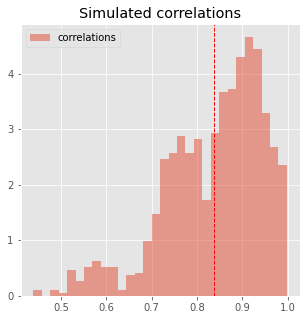

In [10]:
i = random.randrange(len(corr_mats))
M = corr_mats[i].reshape(DIM_MAT*DIM_MAT, 1)

plt.figure(figsize=(5, 5))
plt.title("Simulated correlations")
plt.hist(M, bins=30, log=False, density=True, alpha=0.5, label='correlations')
plt.axvline(x=np.mean(M), color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

### 2. Assets Correlation matrices eigenspectrum follows the Marchenko–Pastur law, with a few large eigenvalues, and one extremely large

Store the eigenvalues.

In [11]:
L = len(corr_mats)
print(L)
out = np.zeros((DIM_MAT, L))

for i in np.arange(len(corr_mats)):
    
    eigenvals, _ = np.linalg.eig(corr_mats[i].reshape(DIM_MAT, DIM_MAT))
    out[:, i] = sorted(eigenvals, reverse=True)

132


/tmp/ipykernel_65393/1285596621.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, i] = sorted(eigenvals, reverse=True)


Sum the largest four eigenvalues compared to sum of all eigenvalues.

In [12]:
def first_large_eigvals_pct(corr_list):
    L = len(corr_list)
    out = np.empty((L, 4))
    for i, corr in enumerate(corr_list):
        eigenvals, _ = np.linalg.eig(corr)
        out[i, :] = np.cumsum(sorted(eigenvals, reverse=True)[:4]) / sum(eigenvals)
    return out

/tmp/ipykernel_65393/986492583.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  out[i, :] = np.cumsum(sorted(eigenvals, reverse=True)[:4]) / sum(eigenvals)


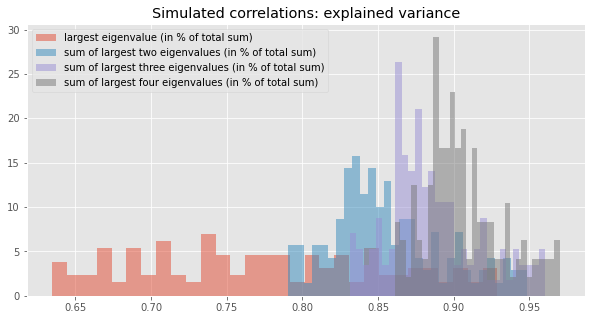

In [13]:
x = first_large_eigvals_pct(corr_mat_list)



plt.figure(figsize=(10, 5))
plt.title("Simulated correlations: explained variance")
plt.hist(x[:, 0], bins=30, log=False, density=True, alpha=0.5, label='largest eigenvalue (in % of total sum)')
plt.hist(x[:, 1], bins=30, log=False, density=True, alpha=0.5, label='sum of largest two eigenvalues (in % of total sum)')
plt.hist(x[:, 2], bins=30, log=False, density=True, alpha=0.5, label='sum of largest three eigenvalues (in % of total sum)')
plt.hist(x[:, 3], bins=30, log=False, density=True, alpha=0.5, label='sum of largest four eigenvalues (in % of total sum)')
plt.legend()
plt.show()

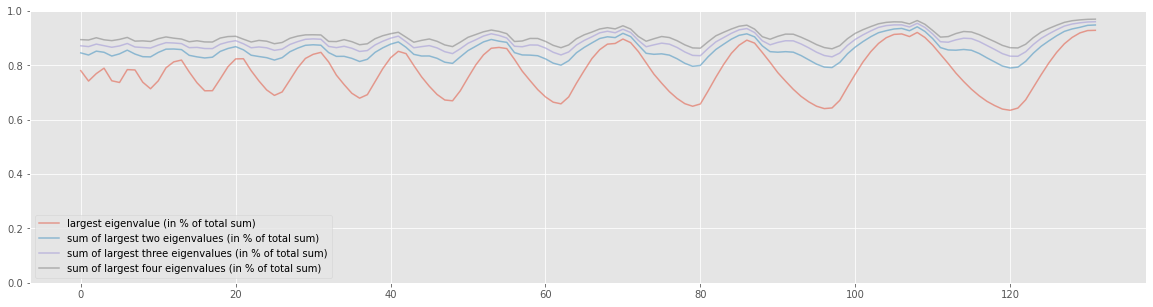

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(x[:, 0], alpha=0.5, label='largest eigenvalue (in % of total sum)')
plt.plot(x[:, 1], alpha=0.5, label='sum of largest two eigenvalues (in % of total sum)')
plt.plot(x[:, 2], alpha=0.5, label='sum of largest three eigenvalues (in % of total sum)')
plt.plot(x[:, 3], alpha=0.5, label='sum of largest four eigenvalues (in % of total sum)')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [15]:
corr_mat_list[0].shape

(32, 32)

In [16]:
L = len(corr_mat_list)
eig1 = np.zeros(L)
eig2 = np.zeros(L)
eig3 = np.zeros(L)

for i, corr in enumerate(corr_mat_list):
    #print(corr.shape)
    eigenvals, _ = np.linalg.eig(corr)
    #print(sorted(eigenvals, reverse=True))
    eig1[i] = sorted(eigenvals, reverse=True)[0]
    eig2[i] = sorted(eigenvals, reverse=True)[1]
    eig3[i] = sorted(eigenvals, reverse=True)[2]

/tmp/ipykernel_65393/797444705.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  eig1[i] = sorted(eigenvals, reverse=True)[0]
/tmp/ipykernel_65393/797444705.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  eig2[i] = sorted(eigenvals, reverse=True)[1]
/tmp/ipykernel_65393/797444705.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  eig3[i] = sorted(eigenvals, reverse=True)[2]


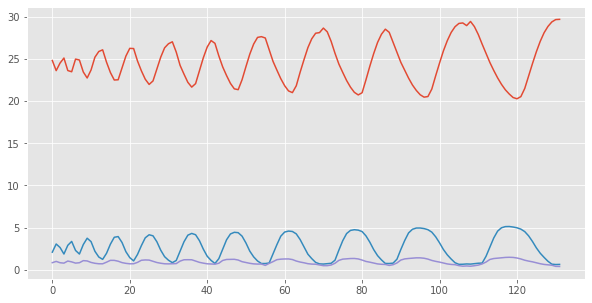

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(eig1)
plt.plot(eig2)
plt.plot(eig3)
plt.show()

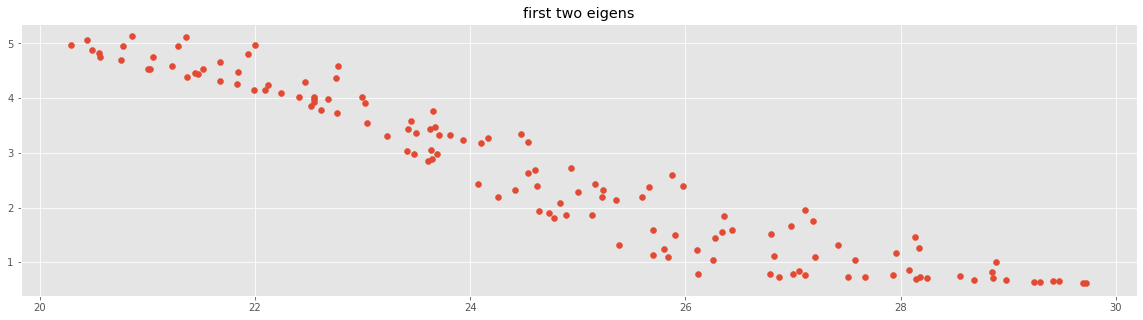

In [18]:
plt.figure(figsize=(20, 5))
plt.title("first two eigens")
plt.scatter(eig1, eig2)
plt.show()

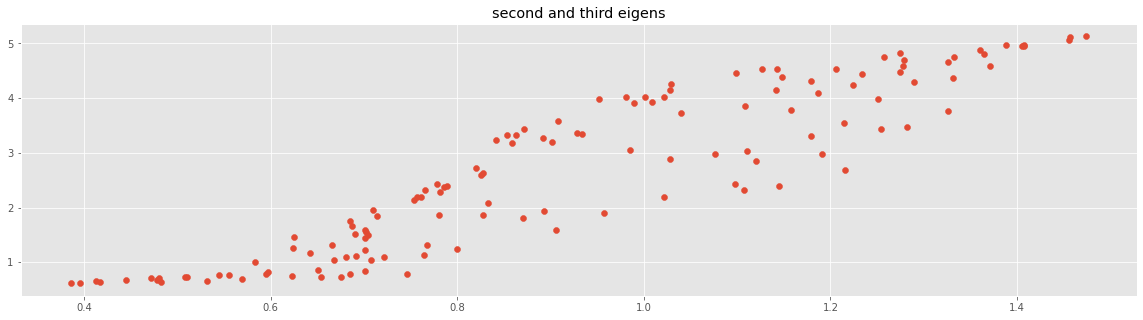

In [19]:
plt.figure(figsize=(20, 5))
plt.title("second and third eigens")
plt.scatter(eig3, eig2)
plt.show()

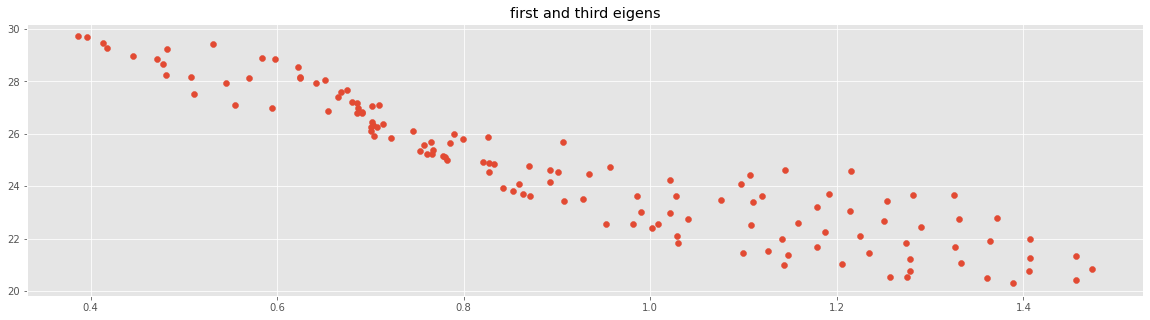

In [20]:
plt.figure(figsize=(20, 5))
plt.title("first and third eigens")
plt.scatter(eig3, eig1)
plt.show()

Using a window of quotations with width W = 100 equates to smoothing correlations over about 9y: the peaks during time of market stress turn out to be "averaged away".

Distribution of the eigenvalues: small eigenvalues are very numerous, then their number decreases with Marchenko-Pastur law, except for a handful of very large eigenvalues.

In [21]:
def compute_eigenvals(correls):
    eigenvalues = []
    for corr in correls:
        eigenvals, eigenvecs = np.linalg.eig(corr)
        eigenvalues.append(sorted(eigenvals, reverse=True))
        
    return eigenvalues

/jupyter/venvs/py38/lib64/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/jupyter/venvs/py38/lib64/python3.8/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/jupyter/venvs/py38/lib64/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


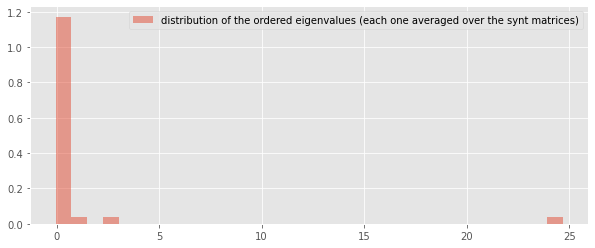

In [22]:
# compute the array of the mean of the first eigenvalues, the mean of the second eigenvalues, etc
sample_mean_eigenvals = np.mean(compute_eigenvals(corr_mat_list), axis=0)
plt.figure(figsize=(10, 4))
plt.hist(sample_mean_eigenvals, bins=DIM_MAT, density=True, alpha=0.5, label='distribution of the ordered eigenvalues (each one averaged over the synt matrices)')
plt.legend()
plt.show()

In [23]:
# Definition of the Marchenko-Pastur density
def marchenko_pastur_pdf(x, lmbd, sigma = 1):
    # lmbd is the ratio: (no. eigenvalues) / (no. realizations)
    b = np.power(sigma * (1 + np.sqrt(lmbd)), 2) # Largest eigenvalue
    a = np.power(sigma * (1 - np.sqrt(lmbd)), 2) # Smallest eigenvalue
    return (1 / (2 * np.pi * sigma * sigma * x * lmbd)) * np.sqrt((b - x) * (x - a)) * (0 if (x > b or x <a ) else 1)

def compare_eigenvalue_distribution(correlation_matrix, lmbd, sigma = 1, set_autoscale = True, show_top = True, bins = 100, is_log_y = False):
    e, _ = np.linalg.eig(correlation_matrix) # Correlation matrix is Hermitian, so this is faster
                               # than other variants of eig
    
    x_min = .0001 if np.power(sigma * (1 - np.sqrt(lmbd)), 2) < .0001 else np.power(sigma * (1 - np.sqrt(lmbd)), 2)
    x_max = np.power(sigma * (1 + np.sqrt(lmbd)), 2)

    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.set_title("Simulated correlations: Marchenko Pastur eigenvalues distribution")
    if is_log_y:
        ax.set_yscale('log')
    #bins = 50
    if not show_top:
        # Clear top eigenvalue from plot
        e=e[e <= x_max + 1]
    ax.hist(e, density = True, bins = bins) # Histogram the eigenvalues
    ax.set_autoscale_on(set_autoscale)

    # Plot the theoretical density
    f = np.vectorize(lambda x: marchenko_pastur_pdf(x, lmbd, sigma = sigma))

    x_min = .000001 if np.power(sigma*(1 - np.sqrt(lmbd)), 2) < .000001 else np.power(sigma*(1 - np.sqrt(lmbd)), 2)
    #x_min = np.power(sigma * (1 - np.sqrt(lmbd)), 2)
    x_max = np.power(sigma * (1 + np.sqrt(lmbd)), 2)
    
    N = 20000 # no. of sampling points
    x = np.linspace(x_min, x_max, 20000)
    dx = (x_max - x_min) / (N - 1)
    if lmbd > 1: # add a probability mass in 0
        y = f(x)
        x = np.insert(x, 0, 0) # prepend 0 at the beginning
        y = np.insert(y, 0, (1 - 1 / lmbd) / dx)
    else:
        y = f(x)
    ax.plot(x, y, linewidth = 1, color = 'b')
    
    
    # check normalization to 1 of Marchenko-Pastur density
    print(sum(y * (x_max - x_min) / (N - 1)))

### 2. Eigenvalues follow the Marchenko–Pastur distribution, except for a very large first eigenvalue and a couple of other large eigenvalues.

0.99999893141594


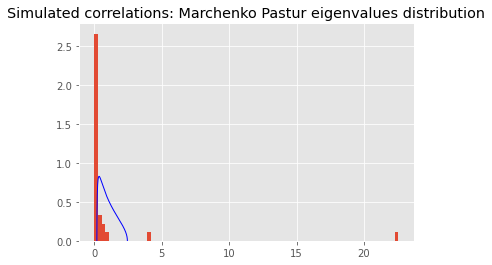

In [24]:
N = DIM_MAT
W = 100
i = random.randrange(len(corr_mat_list))
cor = corr_mats[i].reshape(DIM_MAT,DIM_MAT)
lmbd = N / W
compare_eigenvalue_distribution(cor, lmbd, bins = 80, is_log_y = False)

### 3. Correlation matrices verify the Perron–Frobenius theorem

Perron-Frobenius property: corr matrix (a real square matrix with positive entries) has a unique largest real eigenvalue and the corresponding eigenvector can be chosen to have strictly positive components.

/tmp/ipykernel_65393/1224063958.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  fb_vec_mat[:, i] = fb_vec


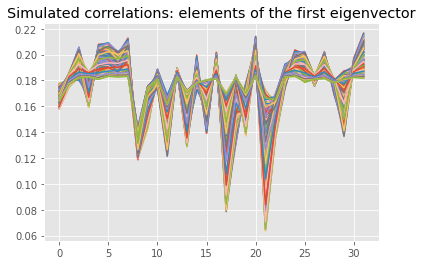

In [25]:
N = len(corr_mat_list) # no. of matrices
I = DIM_MAT # no. of indices, hence dim. of matrices, hence no. of eigenvalues
fb_vec_mat = np.full((I, N), np.nan)
fb_val_check = np.full((N), np.nan)
for i, mat in enumerate(corr_mats):
    val, vec = np.linalg.eig(mat.reshape(DIM_MAT,DIM_MAT))
    
    # check that algebraic multiplicity of largest eigenvalue is 1
    fb_val_check[i] = np.sum(np.isclose(np.max(val), val, atol = 1e-6) == 1)
    
    # check that elements of "largest eigenvector" have homogeneous sign
    fb_vec = vec[:, np.argmax(val)]
    if fb_vec[0] < 0:
        fb_vec = - fb_vec
    fb_vec_mat[:, i] = fb_vec

np.all(np.greater_equal(fb_vec_mat, 0), axis=0), fb_val_check

plt.title("Simulated correlations: elements of the first eigenvector")
plt.plot(fb_vec_mat)
plt.show()

### 4. Correlation matrices have a hierarchical structure
#### calculated on assets correlation

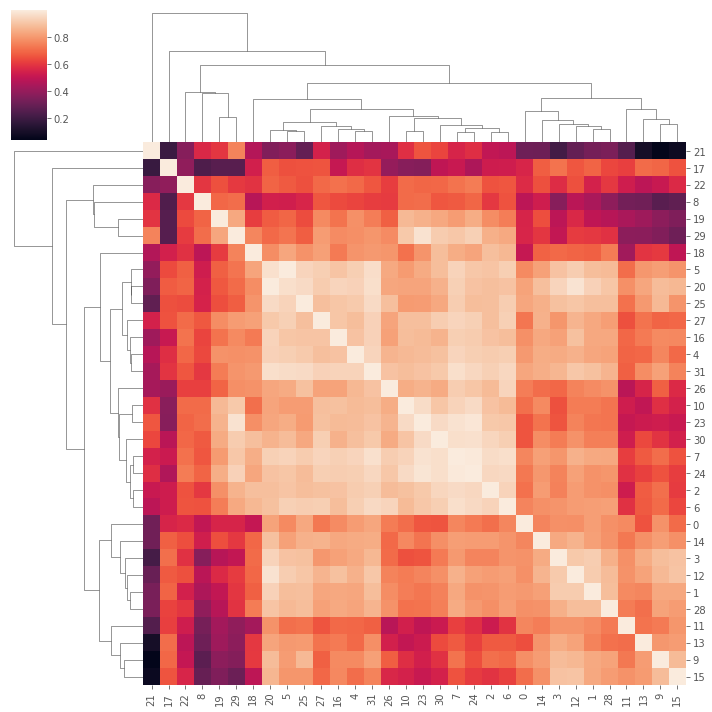

In [26]:
sns.clustermap(corr_mat_list[random.randrange(DIM_MAT)])

### 5. Minimum Spanning Trees extracted from correlation matrices have node degrees seemingly following a power law
#### calculated on assets correlation

In [27]:
def compute_degree_counts(correls):
    all_counts = []
    for corr in correls:
        dist = (1 - corr) / 2
        G = nx.from_numpy_matrix(dist) 
        mst = nx.minimum_spanning_tree(G)

        degrees = {i: 0 for i in range(I)}
        for edge in mst.edges:
            degrees[edge[0]] += 1
            degrees[edge[1]] += 1
        degrees = pd.Series(degrees).sort_values(ascending=False)
        cur_counts = degrees.value_counts()
        counts = np.zeros(I)
        for i in range(I):
            if i in cur_counts:
                counts[i] = cur_counts[i] 

        all_counts.append(counts / (I - 1))
        
    return all_counts

In [28]:
mean_counts = np.mean(compute_degree_counts(corr_mat_list), axis=0)
mean_counts = pd.Series(mean_counts).replace(0, np.nan)

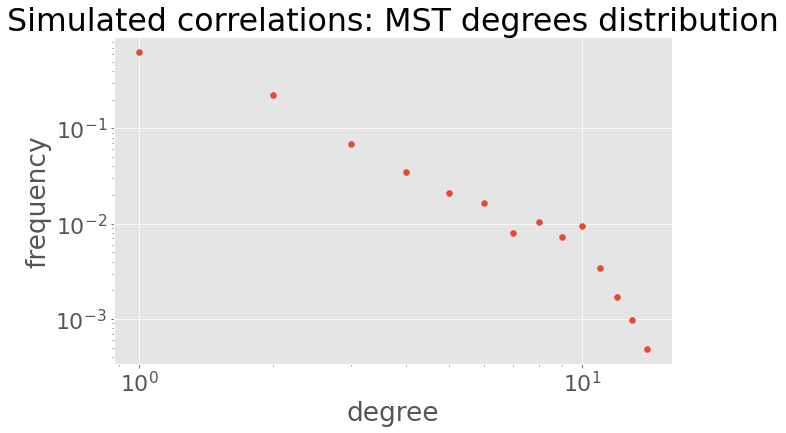

In [29]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.scatter(mean_counts.index, mean_counts)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel('frequency')
plt.xlabel('degree')
plt.title("Simulated correlations: MST degrees distribution")
plt.show()